In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import pchip_interpolate as pch

In [441]:
C_q1 = 3 #unitless, referencing kang's paper for ballpark region estimate
C_q2 = -0.000002 #unitless
q = lambda P: 1 + C_q1 * np.exp(C_q2*P) #q correction factor

L_a = 0.30 #meters
eps = lambda L: (L_a - L)/(L_a) #strain

alpha_0 = 23*np.pi/180 #degrees to radians

D_0 = 0.010 #meters
C_1 = (np.pi*D_0**2)/(4.0)
C_2 = (3)/(np.tan(alpha_0)**2)
C_3 = (1)/(np.sin(alpha_0)**2)
C_4 = C_1*C_2
C_5 = C_1*C_3 


L_fpdf = L_a * 0.9 #length for complementary percent of deformation
def f_a(P, L):
    return P*C_4*(1+(q(P)**2)*(eps(L)**2) - 2*q(P)*eps(L)) - P*C_5

f_a(800000, L_fpdf)
pressures = np.arange(0, 8+1, 1)*100000 #bar to pa
strain = np.linspace(0, 25, 100)/100 #percent to decimal strain
lengths = L_a - L_a*strain

In [442]:
#Lineararize at the actuator length, at 300000 pa / 3 bar
e = -0.1 #linearize at -10% strain
L_0 = L_a + L_a*e
P_g0 = 300000

#Compute the linearized coefficients

Q1p1 = C_4-C_5-2*C_4*((L_a-L_0)/L_a)-2*C_4*((L_a-L_0)/(L_a))*C_q1*(np.exp(C_q2*P_g0)+(P_g0)*C_q2*np.exp(C_q2*P_g0))
Q1p2 = C_4+C_4*(C_q1**2)*(np.exp(2*C_q2*P_g0)+2*(P_g0)*C_q2*np.exp(2*C_q2*P_g0))
Q1p3 = 2*C_4*C_q1*(np.exp(C_q2*P_g0)+(P_g0)*C_q2*np.exp(C_q2*P_g0))
Q1pend = ((L_a**2 + L_0**2 - 2*L_0*L_a)/(L_a**2))
Q_1=Q1p1+(Q1p2 + Q1p3)*Q1pend

Q_2 = (2*P_g0*C_4)/(L_a) + ((2*P_g0*C_4*C_q1)/(L_a))*np.exp(C_q2*P_g0)+(P_g0*C_4+P_g0*C_4*(C_q1**2)*np.exp(2*C_q2*P_g0) + 2*P_g0*C_4*C_q1*np.exp(C_q2*P_g0))*((2*L_0)/(L_a**2) - 2/L_a)

lin_model = lambda dP, dL: Q_1*(dP)+Q_2*(dL)
delta_p = 0
delta_l = 0.00 #meters

f_0 = f_a(P_g0, L_0)

eqn_result = f_a(P_g0+delta_p, L_0+delta_l)
lin_result = f_0+lin_model(delta_p, delta_l)

def calc_lin_model(L_0, P_0):
    #global lin_model
    Q1p1 = C_4-C_5-2*C_4*((L_a-L_0)/L_a)-2*C_4*((L_a-L_0)/(L_a))*C_q1*(np.exp(C_q2*P_g0)+(P_g0)*C_q2*np.exp(C_q2*P_g0))
    Q1p2 = C_4+C_4*(C_q1**2)*(np.exp(2*C_q2*P_g0)+2*(P_g0)*C_q2*np.exp(2*C_q2*P_g0))
    Q1p3 = 2*C_4*C_q1*(np.exp(C_q2*P_g0)+(P_g0)*C_q2*np.exp(C_q2*P_g0))
    Q1pend = ((L_a**2 + L_0**2 - 2*L_0*L_a)/(L_a**2))
    Q_1=Q1p1+(Q1p2 + Q1p3)*Q1pend
    lin_model = lambda dP, dL: Q_1*(dP)+Q_2*(dL)
    return lin_model

print(f"Q1: {Q_1}, Q_2: {Q_2}\nF_0: {f_0}")
print(f"Eqn: {eqn_result}, lin_model: {lin_result}")
print(f"perror: {100*abs((eqn_result-lin_result)/(eqn_result))}")

Q1: 0.0003826875046445771, Q_2: 5089.749769888915
F_0: 57.80921358672626
Eqn: 57.80921358672626, lin_model: 57.80921358672626
perror: 0.0


In [443]:
pressures = np.linspace(0,600000,100)
strains = np.linspace(-0.2,0.05,100)

In [444]:
p_mg, s_mg = np.meshgrid(pressures, strains)

In [445]:
nlin_result = -f_a(p_mg, L_0+s_mg*L_0)
lin_result = f_0+lin_model(p_mg-P_g0, (L_0+e*L_0) - (L_0+s_mg*L_0))
perror = abs(100*(nlin_result-lin_result)/(nlin_result))

/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_44781/1057179328.py:3: RuntimeWarning: divide by zero encountered in divide
  perror = abs(100*(nlin_result-lin_result)/(nlin_result))


In [446]:
perror[perror == -np.inf] = 100
perror[perror == np.inf] = 100

In [447]:
lb = 47
ub = lb+5
print(f"s {np.round(s_mg[40,lb:ub],3)}")
print(f"p {np.round(p_mg[40,lb:ub])}")
print(f"dl {np.round((s_mg*L_0)[40,lb:ub]-L_0, 2)}")
print(f"dp {np.round((p_mg-P_g0)[40,lb:ub],3)}")
print(f"lin {np.round(lin_result[40,lb:ub],2)}")
print(f"nlin {np.round(nlin_result[40,lb:ub],2)}")
print(f"perror {np.round(perror[40,lb:ub],2)}")


s [-0.099 -0.099 -0.099 -0.099 -0.099]
p [284848. 290909. 296970. 303030. 309091.]
dl [-0.3 -0.3 -0.3 -0.3 -0.3]
dp [-15151.515  -9090.909  -3030.303   3030.303   9090.909]
lin [50.62 52.94 55.26 57.58 59.9 ]
nlin [57.1  56.87 56.58 56.24 55.85]
perror [11.34  6.9   2.33  2.38  7.25]


In [448]:
print(f"s {np.round(s_mg[80,45:50],3)}")

s [0.002 0.002 0.002 0.002 0.002]


Text(0.5, 1.0, 'Error Regions for Different Linearization Points')

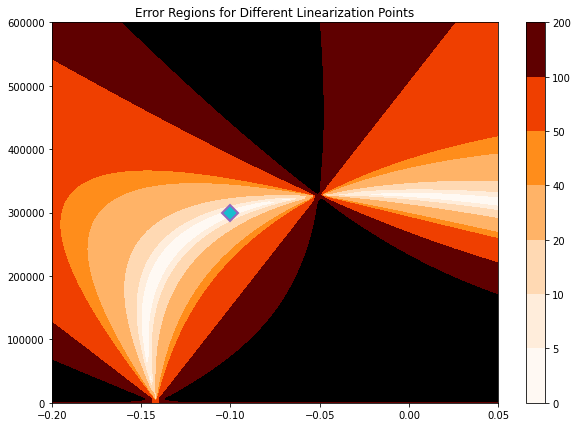

In [451]:
fig, axes = plt.subplots(figsize=(10,7))
h = axes.contourf(s_mg, p_mg, perror, [0,5,10,20,40,50,100,200],cmap="gist_heat_r")
axes.plot(e, P_g0, linestyle=":",color="tab:purple", marker="D", markersize=12, markerfacecolor="tab:cyan",markeredgewidth=2)
axes.set_facecolor('k')
fig.colorbar(h)
axes.set_title("Error Regions for Different Linearization Points")

In [457]:
center_pressures = [200000, 250000, 300000, 350000, 400000]
center_strains = [-0.2, -0.15, -0.1, -0.05, 0.0, 0.05]

/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_44781/3352927627.py:15: RuntimeWarning: divide by zero encountered in divide
  perror = abs(100*(abs(nlin_result)-abs(lin_result))/(abs(nlin_result)))


Text(0.5, 0.98, 'Expected Error/Operating Regions after Linearization')

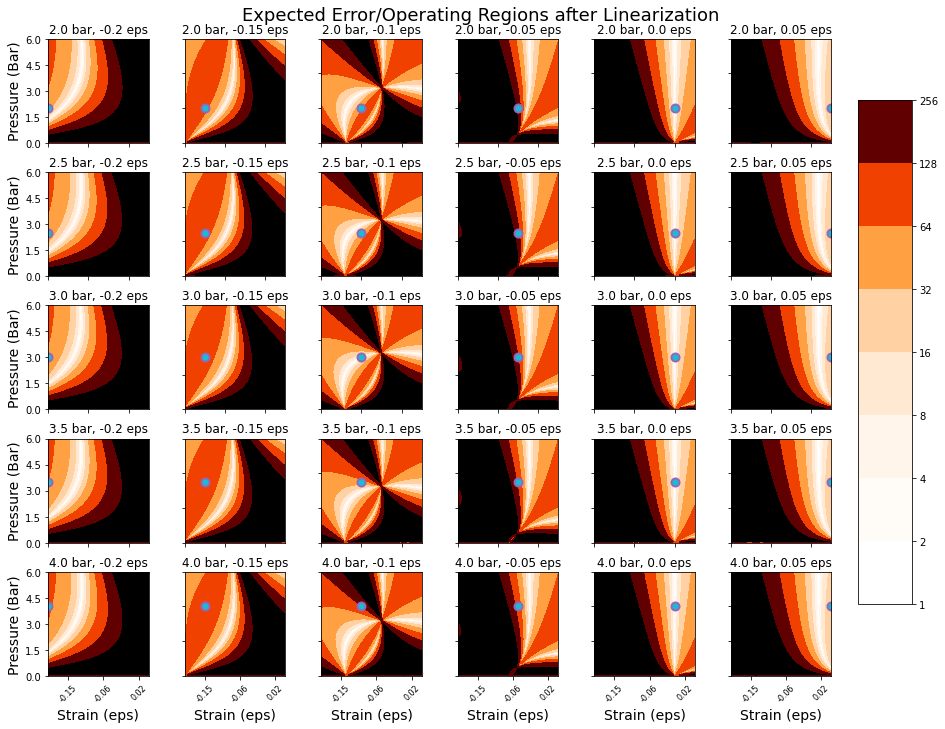

In [460]:
data = dict()
pressures = np.linspace(0,600000,100)
strains = np.linspace(center_strains[0],center_strains[-1],100)
p_mg, s_mg = np.meshgrid(pressures, strains)
fig, axes = plt.subplots(nrows=len(center_pressures), ncols=len(center_strains), figsize=(15,10))
fig.tight_layout(pad=1)

for row, cp in enumerate(center_pressures):
    for col, cs in enumerate(center_strains):
        L_0 = L_a + L_a*cs
        lin_model = calc_lin_model(L_0, cp)
        f_0 = f_a(cp, L_0)
        nlin_result = -f_a(p_mg, L_0+s_mg*L_0)
        lin_result = f_0+lin_model(p_mg-cp, (L_0+cs*L_0) - (L_0+s_mg*L_0))
        perror = abs(100*(abs(nlin_result)-abs(lin_result))/(abs(nlin_result)))
        perror[perror == -np.inf] = 100
        perror[perror == np.inf] = 100
        
        
        #print(f"s {np.round(s_mg[40,lb:ub],3)}")
        #print(f"p {np.round(p_mg[40,lb:ub])}")
        #print(f"dl {np.round(((L_0+cs*L_0) - (L_0+s_mg*L_0))[40,lb:ub], 2)}")
        #print(f"dp {np.round((p_mg-cp)[40,lb:ub],3)}")
        #print(f"lin {np.round(lin_result[40,lb:ub],2)}")
        #print(f"nlin {np.round(nlin_result[40,lb:ub],2)}")
        #print(f"perror {np.round(perror[40,lb:ub],2)}")
        
        h = axes[row][col]
        base = 2
        exp = np.arange(0,9,1)
        legend = np.power(base,exp)
        old_legend = [0,5,10,20,40,50,100,200, 500]
        ctf = h.contourf(s_mg, p_mg, perror, legend,cmap="gist_heat_r")
        #ctf = h.contourf(1-s_mg, p_mg, perror,cmap="gist_heat_r")
        h.set_facecolor('k')
        #fig.colorbar(ctf)
        h.set_title(f"{round(cp/100000, 2)} bar, {round(cs,2)} eps")
        h.plot(cs, cp, linestyle=":",color="tab:purple", marker="o", markersize=8, markerfacecolor="tab:cyan",markeredgewidth=2)
        
        if col == 0:
            h.set_ylabel("Pressure (Bar)", fontsize=14)
            y_ticks = np.linspace(0,600000,5)
            h.set_yticks(y_ticks)
            h.axes.yaxis.set_ticklabels([round(elem/100000, 1) for elem in y_ticks])
            h.tick_params(axis='y', which='major', labelsize=10)
        else:
            h.axes.yaxis.set_ticklabels([])
            
        if row == len(center_pressures)-1:
            h.set_xlabel("Strain (eps)", fontsize=14)
            x_ticks = np.linspace(-0.15,0.2,5)
            h.set_xticks(x_ticks, fontsize=10, rotation=45)
            h.axes.xaxis.set_ticklabels([round(elem, 2) for elem in x_ticks])
            h.tick_params(axis='x', which='major', labelsize=8, rotation=45)
        else:
            h.axes.xaxis.set_ticklabels([])
            
        h.set_ylim((0,600000))
        h.set_xlim((center_strains[0], center_strains[-1]))
        
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ctf, cax=cbar_ax)
plt.subplots_adjust(top=0.935, left=0.1, right=0.825, bottom=0.05)
fig.suptitle("Expected Error/Operating Regions after Linearization", fontsize=18, x=0.5, y=0.98)